In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import time
import copy

from scipy import sparse
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', 100)

# Read Data

## Amazon Fashion

### Full CSJ fashion file

In [12]:
# df = pd.read_pickle('Data/df_amazon_csj_with_styles')
# df.head()

### CSJ 0.63m user above 5, r_u_i

In [20]:
df = pd.read_pickle('Data/df_amazon_csj_with_styles_0.63m_u_above_5_rui')
df.head()

,user,item,rating,verified
0,A2OLY7TMIYHOQQ,B00EAKJUUW,5.0,True
1,A3F6ZP5VM8QUC6,B00D98EGE6,5.0,True
2,A21PFJA2O7Z5GY,B01DTEXSHA,2.0,True
3,AV9HIUYXBZODJ,B0045DBUBQ,3.0,True
4,A73X3PFCRTJVX,B00DEWBMU8,5.0,True


## MovieLens

### 0.7m user above 5 r_u_i

In [14]:
# df = pd.read_pickle('Data/ml_0.7_u_above_5')
# print('rating interval:', df.rating.unique().min(), ',', df.rating.unique().max())
# df.head()

# Data Exploration

First filtering active users and rated items with x or more ratings:

In [47]:
user_ratings = df.groupby('user')['rating'].count()
item_ratings = df.groupby('item')['rating'].count()
norpu = user_ratings.mean()
norpi = item_ratings.mean()
total_users = df.user.unique().size
total_items = df.item.unique().size
sparseness = 1 - len(df) / (len(df['user'].unique()) * len(df['item'].unique()))

## Sub Sample

In [81]:
# df = df.sample(frac=0.9, random_state=1234)

rows  5743 
#ratings 5743 
#ratings/user 1.03 
#ratings/item 1.22 
average rating 1.00 
#users  5560 
#items  4721 
sparse  0.99978 %


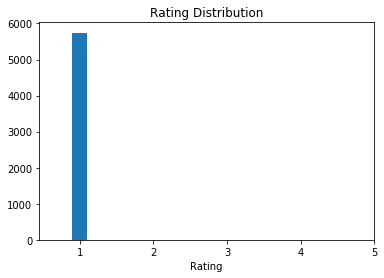

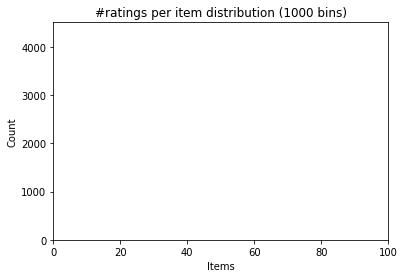

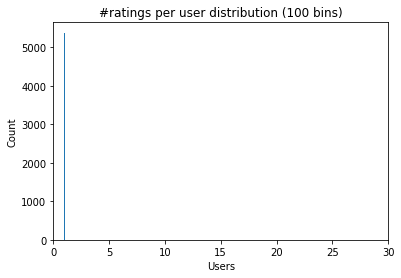

In [48]:
print('rows ', len(df), '\n#ratings', len(df[df['rating'] != 0]), '\n#ratings/user', round(norpu,2), '\n#ratings/item', round(norpi,2), '\naverage rating', "{0:.2f}".format(np.average(df['rating'])), '\n#users ', df['user'].unique().size, '\n#items ', df['item'].unique().size, '\nsparse ', round(sparseness,5), '%')
df.hist(column='rating', bins=5, grid=False)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.xticks(range(1,6))
plt.savefig('Plots/Deliverables/rating_dist_ml')
plt.show()

plt.hist(item_ratings, bins = 1000)
plt.xlim([0,100])
plt.title('#ratings per item distribution (1000 bins)')
plt.xlabel('Items')
plt.ylabel('Count')
plt.savefig('Plots/Deliverables/#ratings_per_item_dist_ml')
plt.show()

plt.hist(user_ratings, bins = 100)
plt.xlim([0,30])
plt.title('#ratings per user distribution (100 bins)')
plt.xlabel('Users')
plt.ylabel('Count')
plt.savefig('Plots/Deliverables/#ratings_per_user_dist_ml')
plt.show()

## Verification Analysis
Only keep verified ratings

In [21]:
print('verified:', df['verified'].sum() / len(df))
df = df[df['verified']==True]
print('verified:', df['verified'].sum() / len(df))

verified: 0.9118257343754217
verified: 1.0


In [23]:
df['verified'] = 1

In [30]:
r = df['rating']
df['rating'] = df['verified']

In [46]:
df_og = df
df = df_og.sample(frac=0.01, random_state=1234)

In [31]:
df.head()

,user,item,rating,verified
0,A2OLY7TMIYHOQQ,B00EAKJUUW,1,1
1,A3F6ZP5VM8QUC6,B00D98EGE6,1,1
2,A21PFJA2O7Z5GY,B01DTEXSHA,1,1
3,AV9HIUYXBZODJ,B0045DBUBQ,1,1
4,A73X3PFCRTJVX,B00DEWBMU8,1,1


# Binary Model

In [42]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [37]:
class SVD:
    """" All functions used to run, test, plot and store the
    Singular Value Decomposition Model"""

    def __init__(self, params, total_users, total_items):
        self.nolf = params['nolf']
        self.n_epochs = params['n_epochs']
        self.alpha = params['alpha']
        self.alpha_b = params['alpha_b']
        self.alpha_cb = params['alpha_cb']
        self.use_bias = params['use_bias']
        self.use_impl_fb = params['use_impl_fb']
        self.use_color = params['use_color']
        self.use_weight_ver = params['use_weight_ver']
        self.bu_reg = params['bu_reg']
        self.bi_reg = params['bi_reg']
        self.pu_reg = params['pu_reg']
        self.qi_reg = params['qi_reg']
        self.x_reg = params['x_reg']
        self.cb_reg = params['cb_reg']
        self.ver_weight = params['ver_weight']
        self.stop = params['stop']
        self.random_state = params['random_state']
        self.total_users = total_users
        self.total_items = total_items
        self.params = params
        self.mu = 0 
        self.N = []
        self.N_test = []
        self.t = pd.DataFrame()
        self.c = pd.DataFrame()
        self.F = pd.DataFrame()

        self.train_data = pd.DataFrame()
        self.test_data = pd.DataFrame()
        self.val_data = pd.DataFrame()
        self.train_time = 0
        self.best_model = {}
        self.model = {}
        self.test_results = {}

    def fit(self, train_data, val_data=[], verbose=1, plot=True, plot_name=''):
        self.train_data = train_data
        self.val_data = val_data
        self.SVD(train_data=train_data, val_data=val_data, verbose=verbose, plot=plot, plot_name=plot_name)
        return self

    
###############################################################################################
    
    def SVD(self, train_data, val_data, verbose, plot, plot_name):
        """"The SVD algorithm with sgd
        input: rating dataset with columns:['rating', 'user_id', 'item_id']
        output: the resulting p, q, bi, bu matrices"""
        self.mu = self.create_mu(train_data)
        train_matrix = self.create_matrix(train_data, self.total_users, self.total_items)
        
        tuples_train = [tuple(x) for x in train_data[['new_user_id', 'new_item_id', 'rating']].to_numpy()]
        
        p = np.random.normal(0, .01, (total_users, self.nolf))  # users
        q = np.random.normal(0, .01, (total_items, self.nolf))  # items
        
        # user and item biases
        b_user = np.zeros(total_users)
        b_item = np.zeros(total_items)
        
        # using color (pareto split (0,1,2)) attribute bias
        if self.use_color:
            print('Creating F and c, for incorporating color bias')
            self.F, self.c = self.init_color(train_data)

        # implicit fb rated, not rated
        x = np.random.normal(0, .1, (total_items, self.nolf))
        impl_fb_u = np.zeros(self.nolf)
        if self.use_impl_fb:
            print('Creating N, for incorporating implicit feedback')
            self.N = train_data.groupby('new_user_id')['new_item_id'].apply(list)
        
        # 0.5 weight on the errors of verified = False user item combinations
        if self.use_weight_ver:
            i_verified = train_data.set_index(['new_user_id', 'new_item_id'])['verified']
            i_verified = i_verified.loc[~i_verified.index.duplicated(keep='first')]
        
        sqrt_Nu = 0
        cb = 0
        rmses = []
        val_rmses = []
        smallest_val_rmse = 10000
        val_rmse = "na"
        start = time.time()
        for epoch in range(self.n_epochs):
            total_sq_error = 0
            for u, i, r_ui in tuples_train:
                u = int(u)
                i = int(i)
                
                if self.use_impl_fb:
                    impl_fb_u = np.zeros(self.nolf)
                    sqrt_Nu = np.sqrt(len(self.N[u]))
                    for j in self.N[u]:
                        impl_fb_u += x[j] / sqrt_Nu

                if self.use_color and epoch > 5:
                    F_ui =  self.F[u,i] #Set of items associated with i and rated by u
                    u_mu = self.mu + b_user[u]
                    sqrt_F_ui = np.sqrt(len(F_ui))
                    for index, f in enumerate(F_ui):
                        r_uf = train_data[(train_data['new_user_id']==u) & (train_data['new_item_id']==f)]['rating'].iloc[0]
                        cb += (r_uf - u_mu) * self.c[u,i][index]
                    cb /=  sqrt_F_ui
                        
                if self.use_bias:   
                    error = r_ui - ((self.mu + b_user[u] + b_item[i] + cb) + np.dot(p[u] + impl_fb_u, q[i]))
                    if self.use_weight_ver and not i_verified[u,i]:
                        error = self.ver_weight * error
                    
                    b_user[u] += self.alpha_b * (error - self.bu_reg * b_user[u])
                    b_item[i] += self.alpha_b * (error - self.bi_reg * b_item[i])
                else:
                    error = r_ui - np.dot(p[u], q[i])

                p[u] += self.alpha * (error * q[i] - self.pu_reg * p[u])
                q[i] += self.alpha * (error * (p[u] + impl_fb_u) - self.qi_reg * q[i])
                total_sq_error += np.square(error)
            
                if self.use_impl_fb:
                    for j in self.N[u]:
                        x[j] += self.alpha * (error * q[i] / sqrt_Nu - self.x_reg * x[j])
                
                if self.use_color and epoch > 5:
                    for index, f in enumerate(F_ui):
                        r_uf = train_data[(train_data['new_user_id']==u) & (train_data['new_item_id']==f)]['rating'].iloc[0]
                        u_mu = self.mu + b_user[u]
                        self.c[u,i][index] += self.alpha_cb * (error * (1/sqrt_F_ui) * (r_uf - u_mu) - self.cb_reg * self.c[u,i][index])
                
            rmse = np.sqrt(total_sq_error / len(tuples_train))
            rmses.append(rmse)
            
            self.model = {'p': p, 'q': q, 'bu':b_user, 'bi':b_item, 'cbu': self.c, 'x':x, 'rmse':rmses, 'val_rmse':val_rmses}
            
            # Validation
            if len(val_data) > 0:
                new_val_rmse = self.test(val_data, val=True)
                val_rmses.append(new_val_rmse)
                if new_val_rmse < smallest_val_rmse:
                    smallest_val_rmse = new_val_rmse
                    self.best_model = copy.deepcopy(self.model)
                val_rmse = new_val_rmse
                
            # Epoch Printing
            if epoch % verbose == 0:
                if len(val_data) > 0:
                    print('Epoch:', epoch, '  RMSE:', rmse, ' Val_RMSE:', val_rmse)
                else:
                    print('Epoch:', epoch, '  RMSE:', rmse)
            
            if self.stop and val_rmses[-2:][0] < val_rmse:
                print('BREAK: Validation set not improving anymore')
                break
                
        if plot:
            self.plot_rmse(rmses, val_rmses, plot_name)

        self.train_time = time.time() - start
        self.model = {'p': p, 'q': q, 'bu':b_user, 'bi':b_item, 'cbu': self.c, 'x':x, 'rmse':rmses, 'val_rmse':val_rmses}
#################################################################################################

    def init_color(self, data_set):
        self.t = data_set.groupby(['new_user_id', 'par_col2'])['new_item_id'].apply(list)
        F = data_set.groupby(['new_user_id', 'new_item_id'])['par_col2'].apply(self.sim_items)
        c = data_set.groupby(['new_user_id', 'new_item_id'])['par_col2'].apply(self.sim_items, random=True)
        return F, c

    def sim_items(self, x, random=False):
        u_id = x.name[0]
        col = x.iloc[0]
        if random:
            return np.random.normal(0,.1,len(self.t[u_id, col]))
        return self.t[u_id, col]
    
    def create_matrix(self, X_train, n_users, n_items):
        r = X_train['new_user_id']
        c = X_train['new_item_id']
        d = X_train['rating']
        train_matrix = sparse.coo_matrix((d, (r, c)), shape=(n_users, n_items))
    
        return train_matrix.tocsr()
    
    def create_mu(self, train_set):
        # Better mean calculation according to https://sifter.org/~simon/journal/20061211.html
        va = train_set.groupby('new_user_id')['rating'].mean().var() #variance mean ratings users
        vb = train_set.groupby('new_item_id')['rating'].mean().var() #variance mean ratings items
        k = va/vb #variance proportion
        better_mu = (train_set['rating'].mean() + train_set['rating'].sum()) / (k+len(train_set))
        return better_mu
    
    def plot_rmse(self, rmse, val_rmses=[], plot_name=''):
        plt.plot(np.arange(len(rmse)), rmse)
        if len(val_rmses) > 0:
            plt.plot(np.arange(len(val_rmses)), val_rmses, color='red')
        plt.title('RMSE')
        plt.xlabel('epoch')
        plt.ylabel('RMSE')
        plt.legend(['Train', 'Validation'])
        if len(plot_name) > 0:
            plt.savefig('Plots/' + plot_name + '.png')
        plt.show()

    def test(self, test_data, val=False):
        if not val:
            self.test_data = test_data
        tuples_test = [tuple(x) for x in test_data[['new_user_id', 'new_item_id', 'rating']].to_numpy()]
        test_matrix = self.create_matrix(test_data, self.total_users, self.total_items)
        
        if self.use_impl_fb and val:
            self.N_test = self.val_data.groupby('new_user_id')['new_item_id'].apply(list)
        elif self.use_impl_fb:
            self.N_test = self.test_data.groupby('new_user_id')['new_item_id'].apply(list)
            
        total_error = 0
        estimates = []
        for u, i, r_ui in tuples_test:
            u = int(u)
            i = int(i)
            est = self.estimate(u, i, test_matrix, test_data)
            estimates.append(est)
            total_error += np.square(r_ui - est)
        
        rmse = np.sqrt(total_error / len(tuples_test))
        
        if not val:
            self.test_results = {'rmse': rmse, 'estimates':estimates}
            print('RMSE on test set:', self.test_results['rmse'])
        else:
            return rmse

    def estimate(self, u, i, test_matrix, test_data):
        est = self.mu + self.model['bu'][u] + self.model['bi'][i]
        impl_fb_u = np.zeros(self.nolf)
        cb = 0
        if u in self.train_data['new_user_id'] and i in self.train_data['new_item_id']:
            
            if self.use_impl_fb and u in self.N.index:
                sqrt_Nu = np.sqrt(len(self.N[u]))
                for j in self.N[u]:   
                    impl_fb_u += self.model['x'][j] / sqrt_Nu
            
            if self.use_color and (u,i) in self.model['cbu']:
                F_ui =  self.F[u,i] #Set of items associated with i and rated by u
                u_mu = self.mu + self.model['bu'][u]
                sqrt_F_ui = np.sqrt(len(F_ui))
                for index, f in enumerate(F_ui):
                    r_uf = self.train_data[(self.train_data['new_user_id']==u) & (self.train_data['new_item_id']==f)]['rating'].iloc[0]
                    cb += (r_uf - u_mu) * self.model['cbu'][u,i][index]
                cb /=  sqrt_F_ui
                
            est += cb + np.dot(self.model['p'][u] + impl_fb_u, self.model['q'][i])

        return est
    
    def store_results(self, log_path, res_name, user_thres, item_thres):
        train_size = round((len(self.train_data) / (len(self.train_data) + len(self.test_data) + len(self.val_data))),1)
        test_size = round((len(self.test_data) / (len(self.train_data) + len(self.test_data) + len(self.val_data))),1)
        val_size = round((len(self.val_data) / (len(self.train_data) + len(self.test_data) + len(self.val_data))),1)
        
        result_info = {'RMSE_test': self.test_results['rmse'], 'train_speed': round(self.train_time,2)}
        other_info = {'u_thres': user_thres,'i_thres': item_thres, 'train_size':train_size, 'test_size':test_size, 'val_size':val_size, 'train_rmse':self.model['rmse'], 'val_rmse':self.model['val_rmse']}
        final_log = dict(result_info, **self.params, **other_info)

        if not os.path.exists(log_path + res_name):
            df_results = pd.DataFrame(columns=final_log.keys())
            print('new results created')

        else:
            df_results = pd.read_pickle(log_path + res_name)
            print('results added')

        df_results = df_results.append(final_log, ignore_index=True)
        pd.to_pickle(df_results, log_path + res_name)

# Data Prep
Create new ids for users and items that match the row and column indices of the user-item interaction matrix

In [51]:
def transform(df):
    items = df['item'].unique()
    itemsDF = pd.DataFrame(data=items, columns=['original_item_id'])
    itemsDF['new_item_id'] = itemsDF.index

    users = df['user'].unique()
    usersDF = pd.DataFrame(data=users, columns=['original_user_id'])
    usersDF['new_user_id'] = usersDF.index

    ratingDF = df.merge(itemsDF, left_on='item', right_on='original_item_id')
    ratingDF = ratingDF.drop(columns=['original_item_id'])

    ratingDF = ratingDF.merge(usersDF, left_on='user', right_on='original_user_id')
    ratingDF = ratingDF.drop(columns=['original_user_id'])

    df_new_ids = ratingDF
    print('Full data #row: ', df_new_ids.shape[0])
    df_new_ids.head()
    
    return df_new_ids

df_new_ids = transform(df)

Full data #row:  5743


## Train Test split
Train 0.8, Train 0.2, Test 0.1, could add validation set

In [52]:
random_state = 1234
train_set, test_set = train_test_split(df_new_ids, test_size=0.20, shuffle=True, random_state=random_state)
val_set, test_set = train_test_split(test_set, test_size=0.50, shuffle=True, random_state=random_state)

print('Size of train set: ', len(train_set))
print('Size of validation set: ', len(val_set))
print('Size of test set: ', len(test_set))

Size of train set:  4594
Size of validation set:  574
Size of test set:  575


# Params

In [125]:
params = {"nolf":20, #Size of latent feature vectors
"n_epochs":10,
"random_state":1234,

#Learning rate
"alpha":0.004, #Low alpha to prevent diverging => sgd all over the place => error up
"alpha_b":0.004,
"alpha_cb":0.001,

"stop":True, #Stops when val set does not improve
"use_bias":True,
"use_color":False,
"use_impl_fb":False,
"use_weight_ver":False,

#Regularizers, still tweaking the values
"bu_reg":0.05,
"bi_reg":0.05,
"pu_reg":0.001,
"qi_reg":0.001,
"x_reg":0.001,
"cb_reg": 0.01,
"ver_weight": 0.5
}

# Train and Test Model

In [54]:
def create_matrix(data, n_users, n_items):
        r = data['new_user_id']
        c = data['new_item_id']
        d = data['rating']
        train_matrix = sparse.coo_matrix((d, (r, c)), shape=(n_users, n_items))
    
        return train_matrix.tocsr()

In [102]:
#init
m_train = create_matrix(train_set, total_users, total_items)
m_val = create_matrix(train_set, total_users, total_items)

p = np.random.normal(0, .1, (total_users, params['nolf']))  # users
q = np.random.normal(0, .1, (total_items, params['nolf']))  # items

In [ ]:
# iterate
s = time.time()
errors = []
for e in range(params['n_epochs']):
    for u in range(total_users):
        for i in range(total_items):
            b_ui = m_train[u,i]
            error = b_ui - np.dot(p[u], q[i])

            #update
            p[u] += params['alpha'] * (error * q[i])# - self.pu_reg * p[u])
            q[i] += params['alpha'] * (error * p[u])# - self.qi_reg * q[i])
            errors.append(np.square(error))
        
t = time.time() - s
print(t)

In [ ]:
t/60

array([[ 0.0201119 ,  0.04274638, -0.06397322, ..., -0.01632348,
        -0.04273308, -0.15113267],
       [ 0.03971113, -0.01264363, -0.07046382, ..., -0.10452278,
        -0.0536095 , -0.09635348],
       [-0.04096794, -0.14322759,  0.01995185, ...,  0.02959881,
         0.06155854, -0.06595029],
       ...,
       [-0.04818621,  0.00795255,  0.08228915, ..., -0.01358225,
        -0.15243568,  0.07716893],
       [ 0.01552269, -0.03250547,  0.19536436, ...,  0.05150944,
        -0.03923679,  0.02893294],
       [-0.05240976, -0.07108371, -0.06748846, ...,  0.0251874 ,
        -0.09964094,  0.04069574]])

## Impl_fb, no reg ML 0.7m

In [41]:
model = SVD(params, total_users, total_items)
model.fit(train_set, val_set, 1, plot=True, plot_name='Amazon_0.63m_svd_train')

C:\Users\robin.opdam\AppData\Local\Continuum\anaconda3\envs\re_research\lib\site-packages\ipykernel_launcher.py:193: RuntimeWarning: invalid value encountered in double_scalars


KeyboardInterrupt: 

In [107]:
model4.test(test_set)

RMSE on test set: 0.8879020055996585


In [108]:
log_path = 'Results/'
res_name = 'diff_amazon_0.63m_ml_0.7m_svd_res'
model4.store_results(log_path, res_name, user_thres, item_thres)

results added


In [109]:
results = pd.read_pickle(log_path + res_name)
results

,RMSE_test,train_speed,nolf,n_epochs,random_state,alpha,alpha_b,alpha_cb,stop,use_bias,use_color,use_impl_fb,use_weight_ver,bu_reg,bi_reg,pu_reg,qi_reg,x_reg,cb_reg,ver_weight,u_thres,i_thres,train_size,test_size,val_size,train_rmse,val_rmse
0,0.974660,735.11,20,40,1234,0.004,0.004,0.001,True,True,False,False,False,0.05,0.05,0.001,0.001,0.001,0.01,0.5,5,5,0.8,0.1,0.1,"[1.0964998875525962, 1.077890991237727, 1.0608...","[1.084106734973401, 1.0758673188719923, 1.0685..."
1,0.888983,465.07,20,40,1234,0.004,0.004,0.001,True,True,False,False,False,0.05,0.05,0.001,0.001,0.001,0.01,0.5,5,5,0.8,0.1,0.1,"[1.0043209703724225, 0.9585997879316766, 0.934...","[0.9806632719832211, 0.9571649684980635, 0.942..."
2,0.901546,4008.69,20,40,1234,0.004,0.004,0.001,True,True,False,True,False,0.05,0.05,0.001,0.001,0.001,0.01,0.5,5,5,0.8,0.1,0.1,"[1.0046325333388055, 0.9575346658147529, 0.932...","[0.9817306182226897, 0.9583214980718305, 0.943..."
3,0.977303,4730.79,20,40,1234,0.004,0.004,0.001,True,True,False,True,False,0.05,0.05,0.001,0.001,0.001,0.01,0.5,5,5,0.8,0.1,0.1,"[1.0972634826578922, 1.0768362886928646, 1.058...","[1.0846694856842962, 1.0764145198595443, 1.069..."
4,0.973846,4631.19,20,40,1234,0.004,0.004,0.001,True,True,False,True,False,0.05,0.05,0.001,0.001,0.500,0.01,0.5,5,5,0.8,0.1,0.1,"[1.097150938913198, 1.0771435306183033, 1.0591...","[1.0839654683510576, 1.07568371842164, 1.06832..."
5,0.889150,5334.53,20,40,1234,0.004,0.004,0.001,True,True,False,True,False,0.05,0.05,0.001,0.001,0.500,0.01,0.5,5,5,0.8,0.1,0.1,"[1.0043539915594077, 0.9584704485902822, 0.934...","[0.9808354598102975, 0.9573517194884253, 0.942..."
6,0.973801,5955.84,20,40,1234,0.004,0.004,0.001,True,True,False,True,False,0.05,0.05,0.001,0.001,2.000,0.01,0.5,5,5,0.8,0.1,0.1,"[1.0969116476784215, 1.077229741787626, 1.0596...","[1.0837589423958007, 1.0754705353744252, 1.068..."
7,0.887902,7476.37,20,40,1234,0.004,0.004,0.001,True,True,False,True,False,0.05,0.05,0.001,0.001,2.000,0.01,0.5,5,5,0.8,0.1,0.1,"[1.004291125392521, 0.9585592188954637, 0.9345...","[0.9806332918833931, 0.9571463139308806, 0.942..."


# View results

In [112]:
results_ml = results[results['RMSE_test'] < 0.95]
results_amazon = results[results['RMSE_test'] > 0.95]

In [129]:
results_amazon.sort_values('RMSE_test')

,RMSE_test,train_speed,nolf,n_epochs,random_state,alpha,alpha_b,alpha_cb,stop,use_bias,use_color,use_impl_fb,use_weight_ver,bu_reg,bi_reg,pu_reg,qi_reg,x_reg,cb_reg,ver_weight,u_thres,i_thres,train_size,test_size,val_size,train_rmse,val_rmse
6,0.973801,5955.84,20,40,1234,0.004,0.004,0.001,True,True,False,True,False,0.05,0.05,0.001,0.001,2.000,0.01,0.5,5,5,0.8,0.1,0.1,"[1.0969116476784215, 1.077229741787626, 1.0596...","[1.0837589423958007, 1.0754705353744252, 1.068..."
4,0.973846,4631.19,20,40,1234,0.004,0.004,0.001,True,True,False,True,False,0.05,0.05,0.001,0.001,0.500,0.01,0.5,5,5,0.8,0.1,0.1,"[1.097150938913198, 1.0771435306183033, 1.0591...","[1.0839654683510576, 1.07568371842164, 1.06832..."
0,0.974660,735.11,20,40,1234,0.004,0.004,0.001,True,True,False,False,False,0.05,0.05,0.001,0.001,0.001,0.01,0.5,5,5,0.8,0.1,0.1,"[1.0964998875525962, 1.077890991237727, 1.0608...","[1.084106734973401, 1.0758673188719923, 1.0685..."
3,0.977303,4730.79,20,40,1234,0.004,0.004,0.001,True,True,False,True,False,0.05,0.05,0.001,0.001,0.001,0.01,0.5,5,5,0.8,0.1,0.1,"[1.0972634826578922, 1.0768362886928646, 1.058...","[1.0846694856842962, 1.0764145198595443, 1.069..."


In [150]:
best_impl_fb = results_amazon.sort_values('RMSE_test').iloc[0]['RMSE_test']
best_basic = results_amazon[results_amazon['use_impl_fb'] == False]['RMSE_test'][0]
print(best_impl_fb, best_basic)

0.9738008513773665 0.97465995560912


(0.86, 0.98)

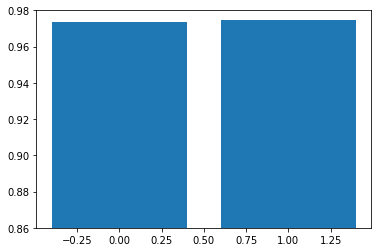

In [162]:
plt.bar(range(2), [best_impl_fb, best_basic])
plt.ylim([0.86,0.98])

In [158]:
results_ml.sort_values('RMSE_test')

,RMSE_test,train_speed,nolf,n_epochs,random_state,alpha,alpha_b,alpha_cb,stop,use_bias,use_color,use_impl_fb,use_weight_ver,bu_reg,bi_reg,pu_reg,qi_reg,x_reg,cb_reg,ver_weight,u_thres,i_thres,train_size,test_size,val_size,train_rmse,val_rmse
7,0.887902,7476.37,20,40,1234,0.004,0.004,0.001,True,True,False,True,False,0.05,0.05,0.001,0.001,2.000,0.01,0.5,5,5,0.8,0.1,0.1,"[1.004291125392521, 0.9585592188954637, 0.9345...","[0.9806332918833931, 0.9571463139308806, 0.942..."
1,0.888983,465.07,20,40,1234,0.004,0.004,0.001,True,True,False,False,False,0.05,0.05,0.001,0.001,0.001,0.01,0.5,5,5,0.8,0.1,0.1,"[1.0043209703724225, 0.9585997879316766, 0.934...","[0.9806632719832211, 0.9571649684980635, 0.942..."
5,0.889150,5334.53,20,40,1234,0.004,0.004,0.001,True,True,False,True,False,0.05,0.05,0.001,0.001,0.500,0.01,0.5,5,5,0.8,0.1,0.1,"[1.0043539915594077, 0.9584704485902822, 0.934...","[0.9808354598102975, 0.9573517194884253, 0.942..."
2,0.901546,4008.69,20,40,1234,0.004,0.004,0.001,True,True,False,True,False,0.05,0.05,0.001,0.001,0.001,0.01,0.5,5,5,0.8,0.1,0.1,"[1.0046325333388055, 0.9575346658147529, 0.932...","[0.9817306182226897, 0.9583214980718305, 0.943..."


In [159]:
best_impl_fb_ml = results_ml.sort_values('RMSE_test').iloc[0]['RMSE_test']
best_basic_ml = results_ml.sort_values('RMSE_test').iloc[1]['RMSE_test']
print(best_impl_fb_ml, best_basic_ml)

0.8879020055996585 0.8889826841707456


(0.86, 0.98)

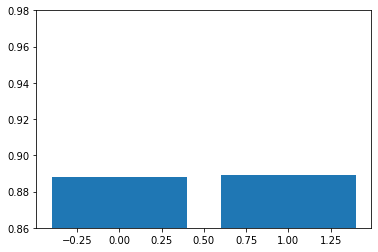

In [163]:
plt.bar(range(2), [best_impl_fb_ml, best_basic_ml])
plt.ylim([0.86,0.98])

## Delete last results

In [ ]:
# pd.read_pickle(log_path + res_name)[1:].to_pickle(log_path + res_name)

# Cross Validation all algs data with #ratings/item & user > 3

In [ ]:
from sklearn.model_selection import KFold
def cv(data, params, n_splits, res_name, model_res_name):
    kf = KFold(n_splits = n_splits, shuffle = True)
    full_data = data
    scores = []

    for i in range(n_splits):
        result = next(kf.split(full_data), None)
        train_set = full_data.iloc[result[0]]
        test_set = full_data.iloc[result[1]]
        model = SVD(params, total_users, total_items)
        model.fit(train_set, verbose = 1000, plot = False)
        
        model.test(test_set)
        model.store_results('', model_res_name, user_thres, item_thres)  

    df_cv_results = pd.read_pickle(model_res_name)[-5:]
    params_dict = df_cv_results.iloc[0][['nolf', 'n_epochs', 'random_state', 'alpha', 'alpha_b', 'use_bias', 'use_impl_fb', 'use_color', 'use_weight_ver', 'ver_weight' 'bu_reg', 'bi_reg', 'pu_reg', 'qi_reg', 'x_reg', 'u_thres', 'i_thres', 'train_size', 'test_size', 'train_rmse']].to_dict()
    avg_rmse_dict = {'avg_rmse_test':np.average(df_cv_results['RMSE_test'])}
    final_dict = {**avg_rmse_dict, **params_dict}

    if not os.path.exists(res_name):
        cv_res = pd.DataFrame(columns=final_dict.keys())
        print('new results created')

    else:
        cv_res = pd.read_pickle(res_name)
        print('results added')

    cv_res = cv_res.append(final_dict, ignore_index=True)
    pd.to_pickle(cv_res, res_name)

## Bias Only

In [ ]:
params

In [ ]:
log_path = 'Results/'
res_name = log_path + 'cv_#ratings_ui_above_3_all_algs'
cv_res_name = log_path + 'cv_#ratings_ui_above_3_bias_only'
n_splits = 5

cv(df_new_ids, params, n_splits, res_name, cv_res_name)

## Weighted Verification and Bias

In [ ]:
params

In [ ]:
params['use_weight_ver'] = True
params['ver_weight'] = 0.7
log_path = 'Results/'
res_name = log_path + 'cv_#ratings_ui_above_3_all_algs'
cv_res_name = log_path + 'cv_#ratings_ui_above_3_ver_weight'
n_splits = 5

cv(df_new_ids, params, n_splits, res_name, cv_res_name)

## Impl_fb with Bias

In [ ]:
params

In [ ]:
params['use_weight_ver'] = False
params['use_impl_fb'] = True
params['x_reg'] = 0.01
log_path = 'Results/'
res_name = log_path + 'cv_#ratings_ui_above_3_all_algs'
cv_res_name = log_path + 'cv_#ratings_ui_above_3_impl_fb'
n_splits = 5

cv(df_new_ids, params, n_splits, res_name, cv_res_name)

## Color attribute with Bias

In [ ]:
params

In [ ]:
params['use_impl_fb'] = False
params['use_color'] = True
log_path = 'Results/'
res_name = log_path + 'cv_#ratings_ui_above_3_all_algs'
cv_res_name = log_path + 'cv_#ratings_ui_above_3_color'
n_splits = 5

cv(df_new_ids, params, n_splits, res_name, cv_res_name)

## Impl_fb with verification weights and Bias

In [ ]:
params

In [ ]:
params['use_impl_fb'] = True
params['use_color'] = False
params['use_weight_ver'] = True
log_path = 'Results/'
res_name = log_path + 'cv_#ratings_ui_above_3_all_algs'
cv_res_name = log_path + 'cv_#ratings_ui_above_3_ver_weight_impl_fb'
n_splits = 5

cv(df_new_ids, params, n_splits, res_name, cv_res_name)

## Color, impl_fb, weight_ver and bias

In [ ]:
params['use_impl_fb'] = True
params['use_color'] = True
params['use_weight_ver'] = True
log_path = 'Results/'
res_name = log_path + 'cv_#ratings_ui_above_3_all_algs'
cv_res_name = log_path + 'cv_#ratings_ui_above_3_bias_impl_fb_weight_color'
n_splits = 5

cv(df_new_ids, params, n_splits, res_name, cv_res_name)

## Results CV all algs

In [ ]:
df_cv_results = pd.read_pickle(res_name).sort_values('avg_rmse_test')
df_cv_results

# Cross Validation

In [ ]:
res_name = 'cv_half_df_all_algs'
cv_res_name = 'cv_res_bias'
log_path = 'Results/'
n_splits = 5

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits = n_splits, shuffle = True)
full_data = df_new_ids
scores = []

for i in range(n_splits):
    result = next(kf.split(full_data), None)
    train_set = full_data.iloc[result[0]]
    test_set = full_data.iloc[result[1]]
    model = SVD(params, total_users, total_items)
    model.fit(train_set, verbose = 1000, plot = False)

    model.test(test_set)
    model.store_results(log_path, cv_res_name, user_thres, item_thres)  

df_cv_results = pd.read_pickle(log_path + cv_res_name)[-5:]
params_dict = df_cv_results.iloc[0][['nolf', 'n_epochs', 'random_state', 'alpha', 'alpha_b', 'use_bias', 'use_impl_fb', 'use_color', 'use_weight_ver', 'bu_reg', 'bi_reg', 'pu_reg', 'qi_reg', 'x_reg', 'u_thres', 'i_thres', 'train_size', 'test_size', 'train_rmse']].to_dict()
avg_rmse_dict = {'avg_rmse_test':np.average(df_cv_results['RMSE_test'])}
final_dict = {**avg_rmse_dict, **params_dict}

if not os.path.exists(log_path + res_name):
    cv_res = pd.DataFrame(columns=final_dict.keys())
    print('new results created')

else:
    cv_res = pd.read_pickle(log_path + res_name)
    print('results added')

cv_res = cv_res.append(final_dict, ignore_index=True)
pd.to_pickle(cv_res, log_path + res_name)

In [ ]:
df_cv_results = pd.read_pickle(log_path + res_name).sort_values('avg_rmse_test')
df_cv_results

# Read and View Results

## All models

In [ ]:
pd.read_pickle(log_path +'all_results_movie_lens')

### Old but gold

In [ ]:
pd.read_pickle('Results/df_comparison_impl_fb')

In [ ]:
df_results = pd.read_pickle('Results/' + 'df_results_svd')
df_results.sort_values('RMSE_test')

Note the RMSE in the first results should be higher (+1.1) due to a mistake in the calculation

In [ ]:
x = ['with Bias and Reg', 'with Bias', 'Plain']
y = [1.313160, 1.314319, 2.860927]

fig, ax = plt.subplots()
ind = np.arange(len(y))
width = 0.8
ax.bar(ind, y, width, color=['darkblue'])
ax.set_xticks(ind+width/500)
ax.set_xticklabels(x, minor=False)
ax.set_ylabel('RMSE')
ax.set_title('Model Comparison')
for i, v in enumerate(y):
    ax.text(i -0.2, v + 0.02, str(v), fontweight='bold')
plt.show()

## Best model train RMSE

### Best from Comparison

In [ ]:
best = df_results_b.iloc[6]
model.plot_rmse(best['train_rmse'])

### Best of All Models

In [ ]:
best = df_results_all
model.plot_rmse(best['train_rmse'])

# Appendix

## Data Split (Pandas)

In [ ]:
# from scipy.linalg import sqrtm

# X_train, X_test = train_test_split(df, test_size=0.10, shuffle=True, random_state=1234)
# X_validation, X_test = train_test_split(X_test, test_size=0.50, shuffle=True, random_state=1234)

# def create_utility_matrix(data, formatizer = {'user':0, 'item': 1, 'value': 2}):
#     """
#         :param data:      Array-like, 2D, nx3
#         :param formatizer:pass the formatizer
#         :return:          utility matrix (n x m), n=users, m=items
#     """
        
#     itemField = formatizer['item']
#     userField = formatizer['user']
#     valueField = formatizer['value']
    
#     userList = data.iloc[:,userField].tolist()
#     itemList = data.iloc[:,itemField].tolist()
#     valueList = data.iloc[:,valueField].tolist()
    
#     users = list(set(data.iloc[:,userField]))
#     items = list(set(data.iloc[:,itemField]))
    
#     users_index = {users[i]: i for i in range(len(users))}
#     pd_dict = {item: [np.nan for i in range(len(users))] for item in items}
    
#     for i in range(0,len(data)):
#         item = itemList[i]
#         user = userList[i]
#         value = valueList[i]
        
#     pd_dict[item][users_index[user]] = value
#     X = pd.DataFrame(pd_dict)
#     X.index = users
        
#     itemcols = list(X.columns)
#     items_index = {itemcols[i]: i for i in range(len(itemcols))}
#     # users_index gives us a mapping of user_id to index of user
#     # items_index provides the same for items
#     return X, users_index, items_index

# X, users_index, items_index = create_utility_matrix(X_train)

hide_toggle()

## Create user item matrix

In [ ]:
# n_users = df.user.unique().shape[0]
# n_items = df.item.unique().shape[0]

# ratings_train = np.zeros((n_users, n_items))
# for row in X_train.itertuples():
#         ratings_train[row[5], row[4]] = row[3]

# pd.DataFrame(ratings_train).head()
# # sparse.csr_matrix((X_train['rating']),shape(n_users, n_items))
hide_toggle()

## Different SGD coding

In [ ]:
# user_item_combos = 0
# for epoch in range(n_epochs):
#     for u in range(ratings_train.shape[0]): #users
#         for i in range(ratings_train.shape[1]): #items
#             r_ui = ratings_train[u,i]
            
#             if  r_ui != 0:
#                 user_item_combos += 1
#                 error = r_ui - np.dot(p[u], q[i])
                
#                 p[u] += alpha *(error * q[i])
#                 q[i] += alpha * (error * p[u])
                
#                 total_error += np.square(error)
# #         print(total_error)
#     rmse = math.sqrt(total_error)
#     print('epoch: ', epoch)#, '  rmse: ', rmse)
#     print(user_item_combos, X_train['rating'].shape[0])
hide_toggle()

## With regularization

In [ ]:
# b_user[u] += alpha_b * (error - bu_reg * b_user[u])
# b_item[i] += alpha_b * (error - bi_reg * b_item[i])
            
# p[u] += alpha * (error * q[i] - pu_reg * p[u])
# q[i] += alpha * (error * p[u] - qi_reg * q[i])
hide_toggle()

## Colors binary split

In [ ]:
# plt.rcParams['figure.figsize'] = [8,6]
# pop_col = (df.groupby('Color:')['rating'].count().sort_values(ascending=False)[0:35]/len(df)).sum()
# non_pop_col = (df.groupby('Color:')['rating'].count().sort_values(ascending=False)[35:]/len(df)).sum()

# bars = plt.bar(['pop_col', 'non_pop_col'], [pop_col, non_pop_col])
# plt.text(bars[0].get_x() + 0.13, pop_col + -0.05, pop_col, color="white", fontweight = 'bold')
# plt.text(bars[1].get_x() + 0.13, non_pop_col + -0.05, non_pop_col, color="white", fontweight = 'bold')
# plt.title('Binary split between 35 most populair colors and non populair colors')
# plt.show()

In [ ]:
# pop_colors = df.groupby('Color:')['rating'].count().sort_values(ascending=False)[0:35] 

# def pop_color(x):
#     x = x['Color:']
#     if x in pop_colors:
#         return 1
#     elif x not in pop_colors:
#         return 0
#     else:
#         return False

# temp_df = pd.DataFrame()
# temp_df['bin_pop_col'] = df.apply(pop_color, axis=1, result_type='expand')
# df = df.merge(temp_df, left_index=True, right_index=True)